# The top 20 greenhouse gas-emitting countries over time

In this project, our goal is to explore World Bank data on greenhouse gas emissions to find out which countries have contributed the most for global warming from 1960 to 2012.

To reach this goal, we'll need to do data cleaning and data visualization.

Along the way of cleaning and visualizing data, we will:

- Use several functions of the pandas and NumPy libraries to clean and manipulate data
- Create a function to nicely visualize missing data using a heatmap
- Web scraping
- Use `applymap` and `lambda` to transform data
- Join datasets with `pandas.DataFrame.merge()`
- Use `for` loops to plot greenhouse emissions of multiple countries

## Datasets 

We will use two datasets from the World Bank Open Data:

- World greenhouse gas emissions by country, available [here](https://data.worldbank.org/indicator/EN.ATM.GHGT.KT.CE?view=chart).
- World population by country, available [here](http://datatopics.worldbank.org/world-development-indicators/themes/people.html).

In [4]:
# let's first import the libraries we'll need in this project.
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [5]:
# Set working directory 
os.chdir("C:/Users/artur/Google Drive/Data_Science/Portifólio/Chill_planet")

# Importing greenhouse gas emissions dataset

## Error while trying to read the dataset

When we try to read the dataset, Python returns a `ParserError`.

In [6]:
#gh_e=pd.read_csv("API_EN.ATM.GHGT.KT.CE_DS2_en_csv_v2_49299.csv")

The `ParserError` occurred because the first rows of the dataset are metada with a different number of fields (columns) than the remaining rows of the dataset, which contain the data we are interested in. See figure below. 

![](dataset_head.png)


To fix this issue, let's use the fifth row as the dataset header. Note that `pd.read_csv()` ignores empty rows, that's why we set `header=2`.

In [32]:
gh_e=pd.read_csv("API_EN.ATM.GHGT.KT.CE_DS2_en_csv_v2_49299.csv",header=2)
print(gh_e.head())

  Country Name Country Code  \
0        Aruba          ABW   
1  Afghanistan          AFG   
2       Angola          AGO   
3      Albania          ALB   
4      Andorra          AND   

                                      Indicator Name     Indicator Code  1960  \
0  Total greenhouse gas emissions (kt of CO2 equi...  EN.ATM.GHGT.KT.CE   NaN   
1  Total greenhouse gas emissions (kt of CO2 equi...  EN.ATM.GHGT.KT.CE   NaN   
2  Total greenhouse gas emissions (kt of CO2 equi...  EN.ATM.GHGT.KT.CE   NaN   
3  Total greenhouse gas emissions (kt of CO2 equi...  EN.ATM.GHGT.KT.CE   NaN   
4  Total greenhouse gas emissions (kt of CO2 equi...  EN.ATM.GHGT.KT.CE   NaN   

   1961  1962  1963  1964  1965     ...               2010          2011  \
0   NaN   NaN   NaN   NaN   NaN     ...                NaN           NaN   
1   NaN   NaN   NaN   NaN   NaN     ...       17791.329902  17981.307287   
2   NaN   NaN   NaN   NaN   NaN     ...       40029.392101  40878.651958   
3   NaN   NaN   NaN   

# Exploring the greenhouse gas emissions dataset

Now that we have opened the dataset, let's explore it a bit.

In [8]:
gh_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 64 columns):
Country Name      264 non-null object
Country Code      264 non-null object
Indicator Name    264 non-null object
Indicator Code    264 non-null object
1960              0 non-null float64
1961              0 non-null float64
1962              0 non-null float64
1963              0 non-null float64
1964              0 non-null float64
1965              0 non-null float64
1966              0 non-null float64
1967              0 non-null float64
1968              0 non-null float64
1969              0 non-null float64
1970              239 non-null float64
1971              238 non-null float64
1972              238 non-null float64
1973              237 non-null float64
1974              236 non-null float64
1975              237 non-null float64
1976              236 non-null float64
1977              237 non-null float64
1978              235 non-null float64
1979              235 

As we can see, the `gh_e` dataset has 264 rows, one for each country and 64 columns, most of them years from 1960 to 2018. However, many year columns are completely empty and many others have varying amounts of missing data.

Let's take a better look at how missing data is distributed over the dataset using a heatmap.

## Writing a function to visualize missing data with heatmap 

A nice way to know how missing data is spread over the dataset is to use a heatmap.
As we will use heatmap to visualize missing data several times in this project, let's write a function called `heat_na`.

In [9]:
# Writing the heat_na function
def heat_na(df,figsize=(12,12)):
    """Displays a heatmap where missing data are represented as empty cells"""
    df_heat=df.set_index(df.iloc[:,0])
    plt.figure(figsize=figsize)
    sns.heatmap(df_heat.isnull(),cbar=False)

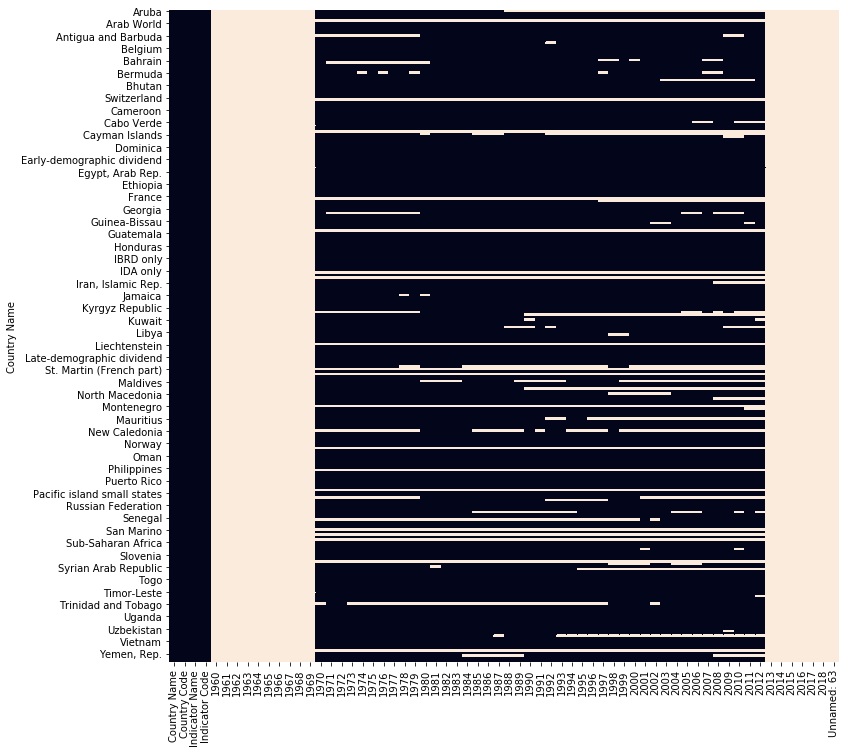

In [10]:
# Time to visualize missing data in the greenhouse gas emissions dataset
heat_na(gh_e)

# Cleaning the greenhouse gas emissions dataset

The heatmap above nicely shows that no greenhouse gas emissions data is available between 1960 and 1969 and between 2013 and 2018. Also, there is a column called `Unamed: 63`, which is completely empty.

Let's drop all columns that are completely empty.

Note that several rows of the greenhouse gas emissions dataset do not represent countries, but groups of countries aggregated by region and income, e.g., `Early demographic-dividend` and `IBRD only`. We will deal with these rows latter. 

In [11]:
# Dropping columns that are completely empty
gh_e=gh_e.dropna(axis=1,how='all')

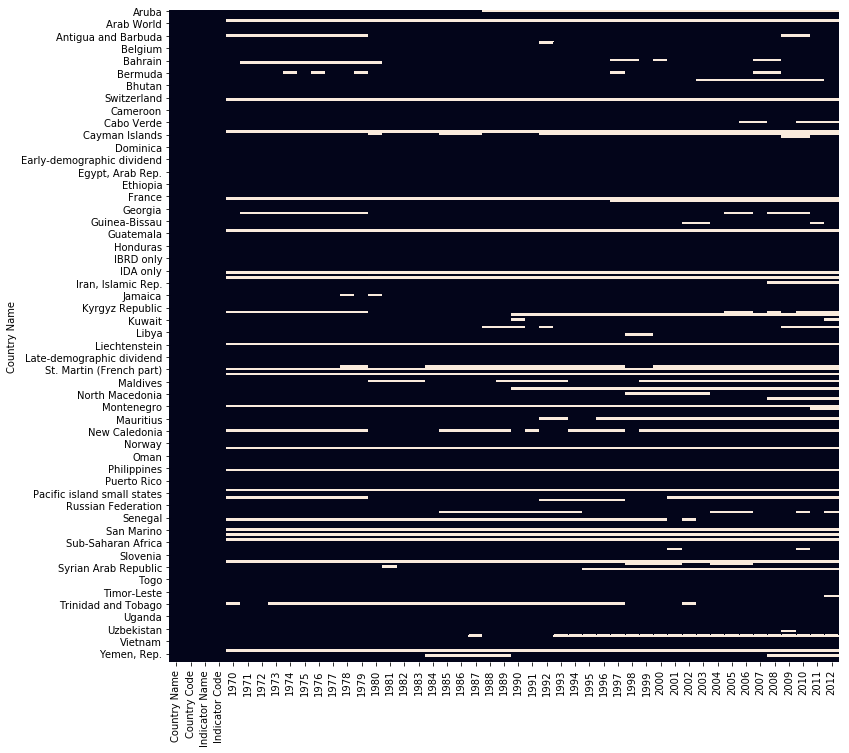

In [12]:
# How does the greenhouse gas emissions dataset look like now?
heat_na(gh_e)

It looks much better! However, greenhouse gas emissions information is completely or partially lacking in many rows.

As the goal of this project is to look at countries' greenhouse gas emissions over time, countries that have incomplete or completely absent greenhouse gas emissions data over time are better to be removed.

Let's drop the rows where greenhouse gas emissions data is lacking.

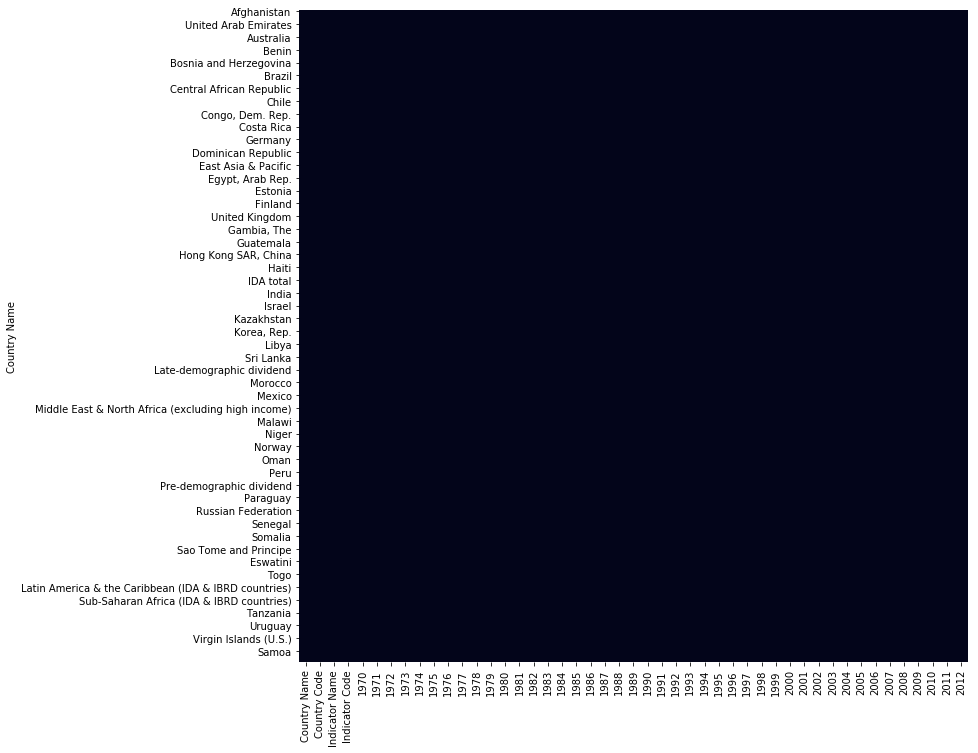

In [13]:
# Keeping only rows with complete greenhouse gas emissions data
cols=gh_e.loc[:,'1970':].columns.tolist() # Specifying the columns from which data must not be absent in any row
gh_e=gh_e.dropna(axis=0,how='any', subset=cols) # Dropping rows lacking greenhouse gas emissions data
heat_na(gh_e)

Now we have a pretty clean dataset to work with! However, it came with a cost because we will work with a much smaller set of countries.

Furthermore, remember that we noticed above that some rows of the greenhouse gas emissions dataset do not represent individual countries, but country categories aggregated by region and income.

Therefore, we need to remove the rows which do not refer to individual countries from the greenhouse gas emissions data set.

## Dropping rows that aggregate groups of countries 

Let's scrap from the web a list of the ISO Alpha-3 country codes, which is used by the World Bank to designate countries by a three-letter combination (e.g., Brazil as BRA).  

A table of the ISO Alpha-3 country codes is available [here](https://www.nationsonline.org/oneworld/country_code_list.htm).

Let's extract the country codes from this table and use them to drop the rows that aggregate groups of countries.

In [14]:
# Scraping country codes from the web
url='https://www.nationsonline.org/oneworld/country_code_list.htm'
countries=requests.get(url).content
country_list=pd.read_html(countries)
country_list[0].head()

,0,1,2,3,4
0,NaN,A,NaN,NaN,NaN
1,NaN,Afghanistan,AF,AFG,4.0
2,NaN,Aland Islands,AX,ALA,248.0
3,NaN,Albania,AL,ALB,8.0
4,NaN,Algeria,DZ,DZA,12.0


In [15]:
# Extracting the countries codes from the list
countries_only=country_list[0][3].values
countries_only

array([nan, 'AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA',
       'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', nan, 'BHS', 'BHR',
       'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL',
       'BIH', 'BWA', 'BVT', 'BRA', 'VGB', 'IOT', 'BRN', 'BGR', 'BFA',
       'BDI', nan, 'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL',
       'CHN', 'HKG', 'MAC', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD',
       'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CYP', 'CZE', nan, 'DNK', 'DJI',
       'DMA', 'DOM', nan, 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'ETH',
       nan, 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', nan,
       'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD',
       'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', nan, 'HTI', 'HMD',
       'VAT', 'HND', 'HUN', 'ISL', nan, 'IND', 'IDN', 'IRN', 'IRQ', 'IRL',
       'IMN', 'ISR', 'ITA', nan, 'JAM', 'JPN', 'JEY', 'JOR', nan, 'KAZ',
       'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 

To remove the rows that aggregate the groups of countries, we will keep in the greenhouse gas emissions dataset only the rows in which values in the column `Country Code` values actually match the `countries_only` elements.

In [16]:
# This code will drop rows that do not refer to individual countries 
gh_e=gh_e[gh_e['Country Code'].isin(countries_only)]

## Cleaning a few things more

Notice the third and fourth columns, `Indicator Name` and `Indicator Code`. What do they mean?

In [17]:
print(gh_e['Indicator Name'].value_counts(),'\n')

print(gh_e['Indicator Code'].value_counts())

Total greenhouse gas emissions (kt of CO2 equivalent)    158
Name: Indicator Name, dtype: int64 

EN.ATM.GHGT.KT.CE    158
Name: Indicator Code, dtype: int64


The `Indicator Name` clarifies that the units of greenhouse gas emissions are equivalent to kilotons (kt) of CO2.
The `Indicator Code` is the code to indicate the data refers to Total greenhouse gas emissions (kt of CO2 equivalent).

Both columns are filled with a unique value each. So, there is no point in keeping them. 

In [18]:
gh_e.drop(columns=['Indicator Name', 'Indicator Code'], inplace=True)
gh_e.head()

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
1,Afghanistan,AFG,14306.61630,14391.77820,13040.84800,13535.75410,14945.96820,14574.16400,14746.85100,15247.28100,...,14709.8840,14654.37400,14770.2643,14849.15940,15272.6330,15288.7756,15554.429500,17791.329902,17981.307287,18168.860000
2,Angola,AGO,60648.60108,39162.17143,42205.65070,44252.66912,40179.23350,44429.30003,38448.02409,43563.41218,...,35858.0150,36860.23340,35855.7384,36375.82200,36690.5340,37396.2940,38309.465126,40029.392101,40878.651958,41657.164846
3,Albania,ALB,6960.86820,6950.03610,7613.26610,7348.49210,7632.66430,7873.03700,8470.97840,8948.98090,...,7834.0157,7401.10155,8308.3856,8027.14955,9879.3935,8136.7850,8108.812387,8506.996034,8712.296365,8898.640911
6,United Arab Emirates,ARE,32962.18941,41377.84513,44905.46275,56875.50782,57411.52655,57798.60342,70352.61920,69646.40020,...,134091.6856,139999.46350,143367.6627,151837.32000,167986.4324,181388.5363,182422.169198,193127.157629,199342.522559,204888.718962
7,Argentina,ARG,221957.02300,213551.78842,223912.27884,226956.03330,229456.38000,233416.77000,247051.66000,247370.86000,...,344797.0600,369944.11000,358385.6400,373600.56000,384547.7500,411503.6300,373409.065637,364684.253846,372873.143758,380295.320369


## Reset the dataset index

As we have removed many rows of the greenhouse gas emissions dataset, let's reset its index to keep things organized.

In [19]:
# Reset the index
gh_e.reset_index(drop=True,inplace=True)
gh_e.head()

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Afghanistan,AFG,14306.61630,14391.77820,13040.84800,13535.75410,14945.96820,14574.16400,14746.85100,15247.28100,...,14709.8840,14654.37400,14770.2643,14849.15940,15272.6330,15288.7756,15554.429500,17791.329902,17981.307287,18168.860000
1,Angola,AGO,60648.60108,39162.17143,42205.65070,44252.66912,40179.23350,44429.30003,38448.02409,43563.41218,...,35858.0150,36860.23340,35855.7384,36375.82200,36690.5340,37396.2940,38309.465126,40029.392101,40878.651958,41657.164846
2,Albania,ALB,6960.86820,6950.03610,7613.26610,7348.49210,7632.66430,7873.03700,8470.97840,8948.98090,...,7834.0157,7401.10155,8308.3856,8027.14955,9879.3935,8136.7850,8108.812387,8506.996034,8712.296365,8898.640911
3,United Arab Emirates,ARE,32962.18941,41377.84513,44905.46275,56875.50782,57411.52655,57798.60342,70352.61920,69646.40020,...,134091.6856,139999.46350,143367.6627,151837.32000,167986.4324,181388.5363,182422.169198,193127.157629,199342.522559,204888.718962
4,Argentina,ARG,221957.02300,213551.78842,223912.27884,226956.03330,229456.38000,233416.77000,247051.66000,247370.86000,...,344797.0600,369944.11000,358385.6400,373600.56000,384547.7500,411503.6300,373409.065637,364684.253846,372873.143758,380295.320369


## Rounding greenhouse gas emissions data to two decimal cases

The numeric values of the greenhouse gas emissions dataset have six decimal cases. We don't need such precision. Let's reduce the number of decimal cases to two.

In [20]:
gh_e=gh_e.round(2)
gh_e.head()

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Afghanistan,AFG,14306.62,14391.78,13040.85,13535.75,14945.97,14574.16,14746.85,15247.28,...,14709.88,14654.37,14770.26,14849.16,15272.63,15288.78,15554.43,17791.33,17981.31,18168.86
1,Angola,AGO,60648.60,39162.17,42205.65,44252.67,40179.23,44429.30,38448.02,43563.41,...,35858.02,36860.23,35855.74,36375.82,36690.53,37396.29,38309.47,40029.39,40878.65,41657.16
2,Albania,ALB,6960.87,6950.04,7613.27,7348.49,7632.66,7873.04,8470.98,8948.98,...,7834.02,7401.10,8308.39,8027.15,9879.39,8136.78,8108.81,8507.00,8712.30,8898.64
3,United Arab Emirates,ARE,32962.19,41377.85,44905.46,56875.51,57411.53,57798.60,70352.62,69646.40,...,134091.69,139999.46,143367.66,151837.32,167986.43,181388.54,182422.17,193127.16,199342.52,204888.72
4,Argentina,ARG,221957.02,213551.79,223912.28,226956.03,229456.38,233416.77,247051.66,247370.86,...,344797.06,369944.11,358385.64,373600.56,384547.75,411503.63,373409.07,364684.25,372873.14,380295.32


# Visualizing total greenhouse gas emissions by country over time

Now that we have cleaned-up our dataset, let's visualize the amount of greenhouse gas emissions world countries released in the atmosphere from 1970 to 2012.

First, we will add the total amount of greenhouse gas emissions per year for each country, then we will rank the top greenhouse gas-emitting countries.

In [21]:
# Summing greenhouse gas emissions by country
gh_e['Total_gh_e']=gh_e.iloc[:,2:].sum(axis=1)
gh_e[['Country Name','Total_gh_e']].head(20)

,Country Name,Total_gh_e
0,Afghanistan,609044.65
1,Angola,1793541.55
2,Albania,375593.03
3,United Arab Emirates,4150472.46
4,Argentina,12425457.59
5,Armenia,491458.88
6,American Samoa,1248.22
7,Australia,27434139.72
8,Austria,3519779.71
9,Burundi,149459.30


Notice that when we add greenhouse gas emissions by country over the years, the magnitude of the values in the column `Total_gh_e` is at least one order of magnitude greater than the values in the year columns.  The current unit of greenhouse gas emissions is in kilotonnes (kt). Let's convert kt to megatonnes (mt) so that we have numbers of smaller magnitude. This will improve data visualization.

## Using `applymap` and `lambda` function to change greenhouse gas emissions units

To convert kt to mt, we simply need to divide the values in kt by 1000.

In [22]:
# Skip the first two non-numeric columns and divide the others by 1000
gh_e=gh_e.applymap(lambda x: x/1000 if type(x)==float else x).round(2) 
gh_e.head()

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,Total_gh_e
0,Afghanistan,AFG,14.31,14.39,13.04,13.54,14.95,14.57,14.75,15.25,...,14.65,14.77,14.85,15.27,15.29,15.55,17.79,17.98,18.17,609.04
1,Angola,AGO,60.65,39.16,42.21,44.25,40.18,44.43,38.45,43.56,...,36.86,35.86,36.38,36.69,37.40,38.31,40.03,40.88,41.66,1793.54
2,Albania,ALB,6.96,6.95,7.61,7.35,7.63,7.87,8.47,8.95,...,7.40,8.31,8.03,9.88,8.14,8.11,8.51,8.71,8.90,375.59
3,United Arab Emirates,ARE,32.96,41.38,44.91,56.88,57.41,57.80,70.35,69.65,...,140.00,143.37,151.84,167.99,181.39,182.42,193.13,199.34,204.89,4150.47
4,Argentina,ARG,221.96,213.55,223.91,226.96,229.46,233.42,247.05,247.37,...,369.94,358.39,373.60,384.55,411.50,373.41,364.68,372.87,380.30,12425.46


## Ranking the top greenhouse gas-emitting countries

Let's find out which are the top 20 greenhouse gas-emitting countries between 1970 and 2012. 

In [23]:
# Reordering the rows of the dataframe in descending order based on the total greenhouse gas emissions 
gh_e_sort=gh_e.sort_values(by='Total_gh_e',ascending=False)
gh_e_sort[['Country Name','Total_gh_e']].head(20)

,Country Name,Total_gh_e
148,United States,269490.99
27,China,211727.56
122,Russian Federation,123464.35
19,Brazil,69080.62
70,India,65860.83
77,Japan,54011.51
37,Germany,50460.77
69,Indonesia,48193.90
30,"Congo, Dem. Rep.",43775.21
53,United Kingdom,31783.53


Let's plot the total amounts of greenhouse gas emitted by these countries between 1970 and 2012.  

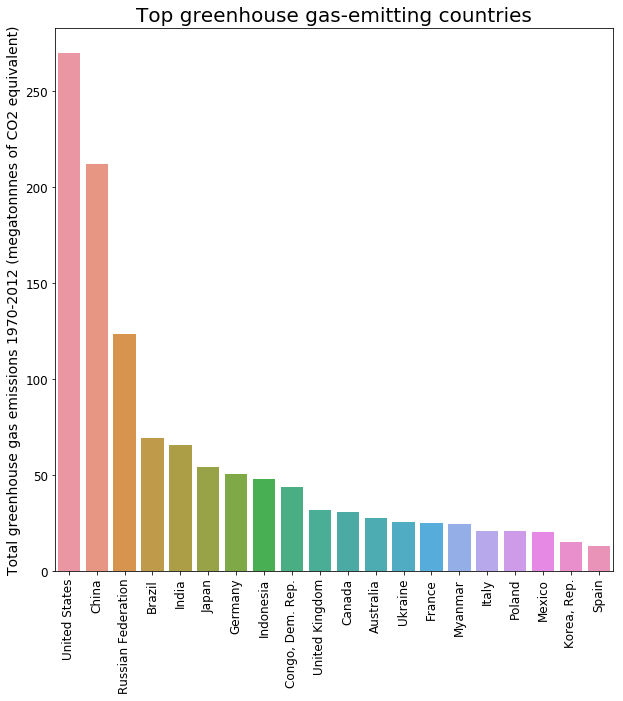

In [24]:
plt.figure(figsize=(10,10))
plt.title('Top greenhouse gas-emitting countries', fontsize=20)
sns.barplot(gh_e_sort['Country Name'].head(20),(gh_e_sort['Total_gh_e']/1000).head(20))
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Total greenhouse gas emissions 1970-2012 (megatonnnes of CO2 equivalent)',fontsize=14)
plt.tick_params(labelsize=12)

The United States and China are by far the most greenhouse gas-emitting countries, each releasing amounts of greenhouse gases equivalent to more than 200 mt of CO2. After them, Russia has the most outstanding amount of greenhouse gas emissions. Then, a steady decrease of greenhouse gas emissions is observed for the rest of the top 20 greenhouse gas-emitting countries.

# Visualizing greenhouse gas emissions per year

To plot greenhouse gas emissions per year, we will use `pd.melt()`function convert our dataset to a tidy format.

In [25]:
# Melting the dataframe
gh_e_melt=pd.melt(gh_e_sort,id_vars='Country Name',value_vars=gh_e_sort.loc[:,'1970':'2012'],var_name='Year',value_name='Total_gh_e')
gh_e_melt.head()

,Country Name,Year,Total_gh_e
0,United States,1970,5400.50
1,China,1970,1873.97
2,Russian Federation,1970,2240.87
3,Brazil,1970,1260.98
4,India,1970,746.50


## Using `for` loop to plot greenhouse gas emissions of the top 20 greenhouse gas-emitting countries 

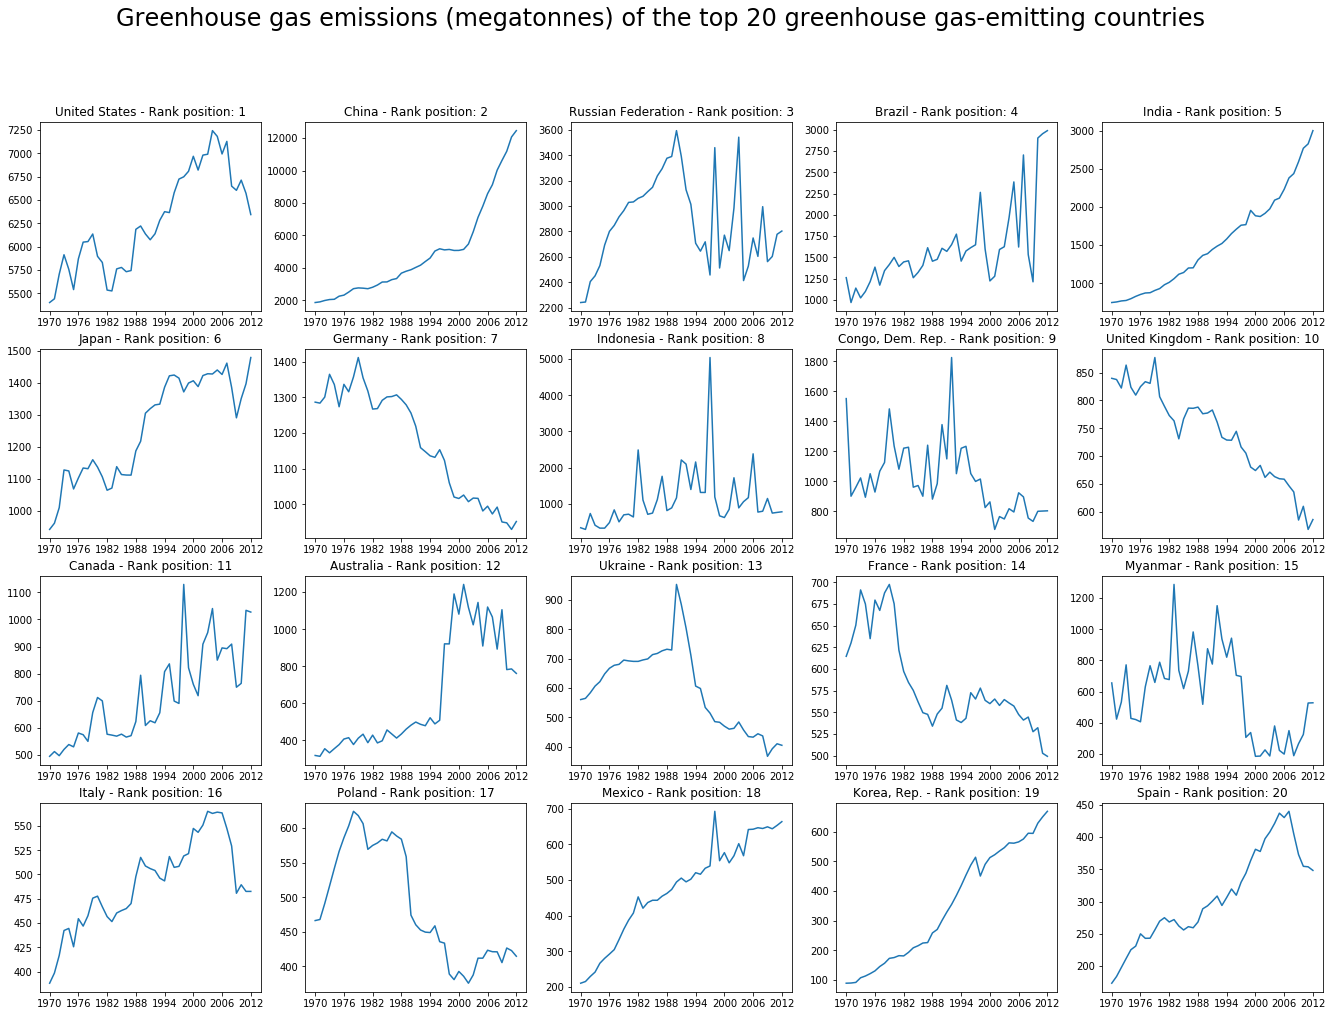

In [26]:
# Plotting historical greenhouse gas emissions records of the top 20 emitters
subplots_list=list(range(20)) # Creates a list with the same number of subplots generated below
top_list=gh_e_melt.iloc[:20,0].tolist() # Creates a list with the names of the top 20 greenhouse gas-emitting countries

fig=plt.figure(figsize=(23,16))
fig.suptitle('Greenhouse gas emissions (megatonnes) of the top 20 greenhouse gas-emitting countries',fontsize=24)

for x,y in zip(subplots_list,top_list):
    ax=fig.add_subplot(4,5,x+1)
    top_country=gh_e_melt[gh_e_melt['Country Name']==y]
    rank='Rank position: {}'.format(x+1)
    ax.plot(top_country['Year'],top_country['Total_gh_e'])
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    ax.set_title('{} - Rank position: {}'.format(y,x+1),fontsize=12)

Three main patterns of greenhouse gas emissions can be observed. 

The first pattern is an increasing trend of greenhouse gas emissions, defined by levels of emissions in 2012 greater than the emission levels of all precedent years. This pattern is observed in China, Brazil, India, Japan and the Republic of Korea (South Korea). 

The second pattern also shows an increasing trend of greenhouse gas emissions but distinguishes from the first pattern because greenhouse emissions levels in 2012 were smaller than have been in one or more precedent years. This pattern is observed in the USA, Russia, Indonesia, Canada, Australia, Italy, Mexico, and Spain. 

The third pattern is a decreasing trend of greenhouse gas emissions between 1970 and 2012, defined by smaller greenhouse gas emissions levels in 2012 than in 1970. This pattern is observed in seven countries: Germany, Congo, UK, Ukraine, France, Myanmar, and Poland. 

# Visualizing greenhouse gas emissions per capita

## Reading countries population data 

The plots above display the absolute greenhouse gas emissions. However, it's hard to draw comparisons based on absolute greenhouse gas emissions because some countries are orders of magnitude greater than others. For instance, whereas China had about 1.3 billion people living there in 2012, France had about 65 million people.

Let's tandardize greenhouse gas emissions by population size (greenhouse gas emissions per capita).

In [27]:
# Reading the population data
pop=pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_126182.csv',header=2)
pop.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,...,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,NaN


Let's drop the columns `Indicator Name` and `Indicator Code`, we don't need this information.

In [28]:
pop=pop.drop(columns=['Indicator Name', 'Indicator Code'])
pop.head()

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
1,Afghanistan,AFG,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,10174836.0,10399926.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN
2,Angola,AGO,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,5781214.0,5774243.0,...,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,NaN
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,NaN
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,NaN


## Combining greenhouse gas emissions data with countries' population data using `pd.merge()`

We will join `gh_e_sort` and `pop` based on the country codes that are shared by both datasets. Remember that we dropped many countries from our original greenhouse gas emissions data because of missing data. So the countries present in`gh_e_sort` are a subset of the countries listed in `popul`. 

However, before merging we need to reshape `pop` to a tidy format as we did for gh_e_melt

In [29]:
# Tidying countries population data
pop_melt=pd.melt(pop,id_vars='Country Name',value_vars=pop.loc[:,'1970':'2012'],var_name='Year',value_name='Total_population')
pop_melt.head()

,Country Name,Year,Total_population
0,Aruba,1970,59063.0
1,Afghanistan,1970,11173642.0
2,Angola,1970,5890365.0
3,Albania,1970,2135479.0
4,Andorra,1970,24276.0


In [30]:
# Joining greenhouse gas emission and countries population data
gh_e_pop=pd.merge(gh_e_melt,pop_melt,how='left')
gh_e_pop.head()

,Country Name,Year,Total_gh_e,Total_population
0,United States,1970,5400.50,205052000.0
1,China,1970,1873.97,818315000.0
2,Russian Federation,1970,2240.87,130404000.0
3,Brazil,1970,1260.98,95113265.0
4,India,1970,746.50,555189792.0


## Using `for` loop to plot per capita greenhouse gas emissions in the top 20 greenhouse gas-emitting countries


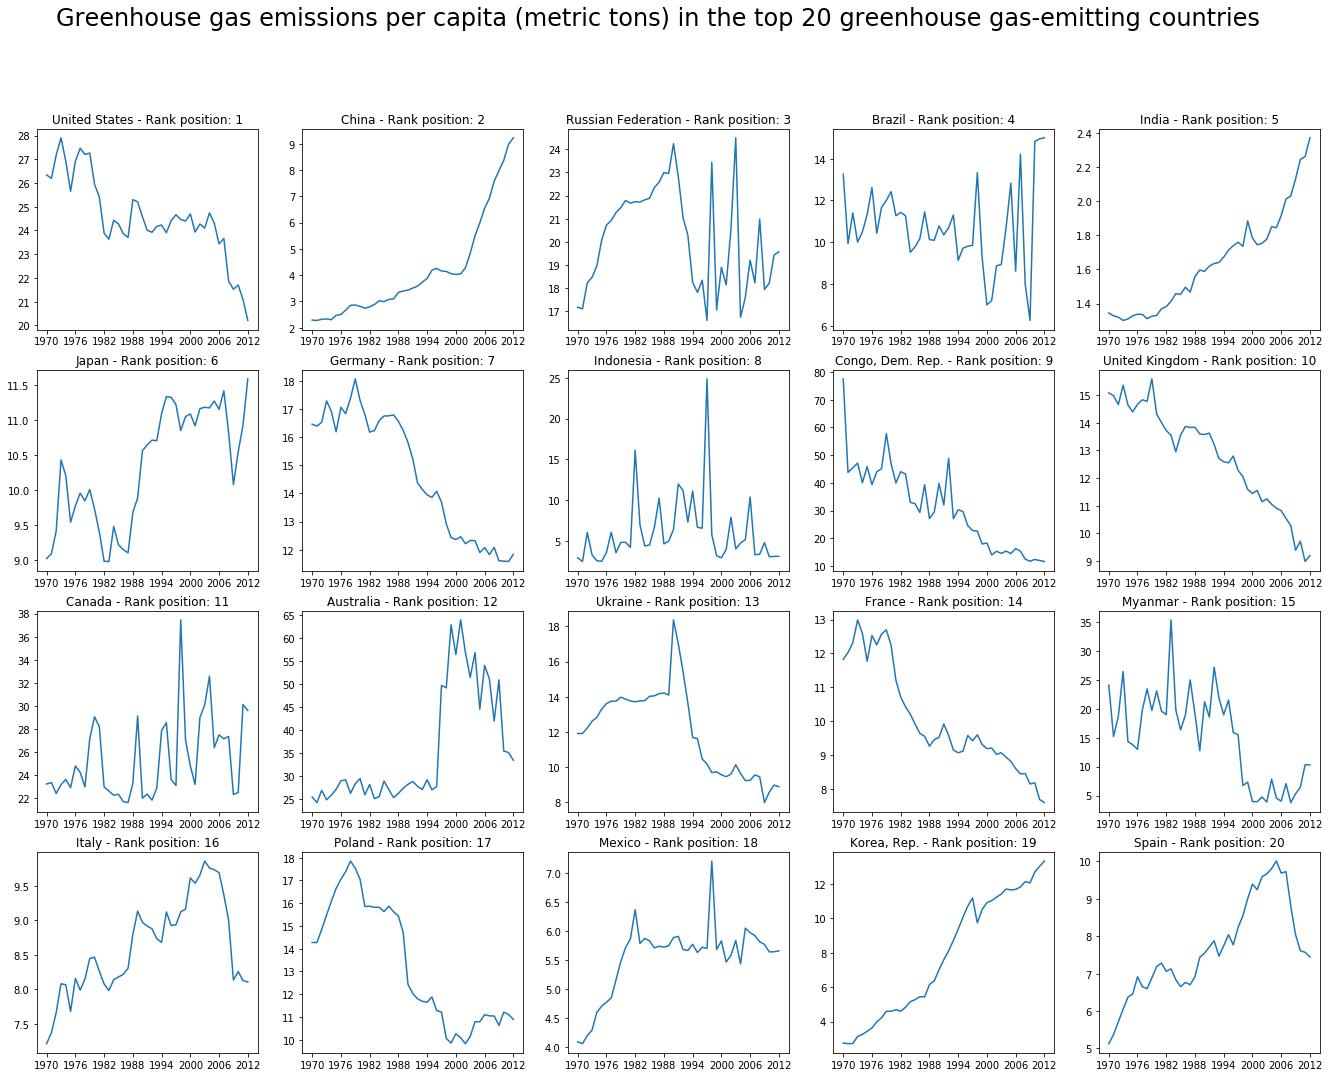

In [31]:
subplots_list=list(range(20)) # Creates a list with the same number of subplots generated below
top_c_list=gh_e_melt.iloc[:20,0].tolist() # Creates a list with the names of the top 20 greenhouse gas-emitting countries

fig=plt.figure(figsize=(23,17))
fig.suptitle('Greenhouse gas emissions per capita (metric tons) in the top 20 greenhouse gas-emitting countries',fontsize=24)


for x,y in zip(subplots_list,top_list):
    ax=fig.add_subplot(4,5,x+1)
    top_country=gh_e_pop[gh_e_pop['Country Name']==y]
    ax.plot(top_country['Year'],top_country['Total_gh_e']*1e+6/top_country['Total_population'])
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    ax.tick_params(which='major')
    ax.set_title('{} - Rank position: {}'.format(y,x+1),fontsize=12)

Greenhouse gas emissions per capita parallel absolute greenhouse gas emissions (see the previous panel showing total greenhouse gas emissions over time) in most of the 20 greenhouse gas-emitting countries. The convergence between per capita and absolute greenhouse gas emissions indicates individual consumerism absolute greenhouse gas emissions are tightly linked.

The few exceptions are the USA, Congo, and Mexico.

Per capita greenhouse gas emissions in the USA decreased between 1970 and 2012, but total greenhouse gas emissions increased in this time frame. This indicates that total greenhouse gas emissions in the USA increased over the years because its population increased since 1970, but individual consumerism has decreased over time.

In Congo, greenhouse gas emissions per capita decreased by about eight times, whereas absolute greenhouse gas emissions decreased by about 50%. Meanwhile, Congo's population increased more than four times between 1970 and 2012. Therefore, the steeper decrease in per capita than in absolute greenhouse gas emissions in Congo sadly reflects the fact that Congolese are among the poorest people on Earth.

In Mexico, greenhouse gas emissions remained mostly constant since the 80's, although absolute greenhouse gas emissions increased steeply between 1970 and 2012. This means that the absolute increase in greenhouse gas emissions in Mexico, at least since the 80's, is mostly a product of population growth rather than increased individual consumerism.

# Conclusions

Many data missing for years and countries

Three patterns of gas emmision

Individual consumerism within countries is usually accompanied by total greenhouse gas emmissions